In [1]:
import pandas as pd
import numpy as np
import os as os
import acessos as ac
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

## QUERY

In [2]:

dt_query = "2020-12-01"

In [3]:
query = f"""

with base_aprovados as (
	select 
	dt_mes,
	sum(qtd_contas_total_acum) as qtd_contas_total_acum,
	sum(contas_novas) as contas_novas
	from platform_analytics_zone.monthly_kpis_pag_will 
	group by 1
)
, chats_agg as (
	select 
	dt_chat,
 	max(qtd_contas_total_acum) as qtd_contas_total_acum,
	max(contas_novas) as contas_novas,
  	max(is_holiday) as is_holiday,
	max(is_holiday_or_event) as is_holiday_or_event,
	max(is_eve) as is_eve,
	max(is_post) as is_post,
 	max(case when ds_holiday_or_event = 'Natal' then 1 else 0 end) as flag_natal,
	max(case when ds_holiday_or_event = 'Carnaval' and is_holiday = 1  then 1 else 0 end) as flag_carnaval,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) <= 5 then 1 else 0 end) as flag_5,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 6 and 10 then 1 else 0 end) as flag_6_10,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 11 and 15 then 1 else 0 end) as flag_11_15,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 16 and 20 then 1 else 0 end) as flag_16_20,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 21 and 25 then 1 else 0 end) as flag_21_26,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 26 and 31 then 1 else 0 end) as flag_26_mais,
  	count(distinct id_issue) as chats
	FROM cx_curated_zone.cx_contact_rate c
 	left join base_aprovados a on (a.dt_mes = date_trunc('month', cast(c.dt_chat as date)))
  	left join customer_curated_zone.ca_dict_events e on (e.dt_date = cast(c.dt_chat as date))
	where dt_chat >= to_date('{dt_query}','yyyy-mm-dd')
	and dt_chat < date_add('day', -2, now())
	group by 1
)
, cartao_agg as (
	select 
	dia
	, SUM(ativos_dia) as ativos_dia 
	, SUM(spending_dia) as spending_dia 
	from platform_analytics_zone.daily_spending_pag_will
	where cast(dia as date) >= to_date('{dt_query}','yyyy-mm-dd')
	group by 1
	order by 1
)
select
c.dt_chat
, chats
, qtd_contas_total_acum
, contas_novas
, ativos_dia
, is_holiday
, is_eve
, is_post
, flag_natal
, flag_carnaval
, spending_dia
from chats_agg c
left join cartao_agg ct on (c.dt_chat = cast(ct.dia as date))
order by dt_chat asc


"""

In [20]:
df = ac.df_athena('flavia-costa', query)

In [21]:
df['chats_cliente']  = df['chats'] / df['qtd_contas_total_acum']
df['spending_cliente']  = df['spending_dia'] / df['qtd_contas_total_acum']
df['ativos_cliente']  = df['ativos_dia'] / df['qtd_contas_total_acum']


In [25]:
df.head()

,dt_chat,chats,qtd_contas_total_acum,contas_novas,ativos_dia,is_holiday,is_eve,is_post,flag_natal,flag_carnaval,spending_dia,chats_cliente,spending_cliente,ativos_cliente
0,2020-12-01,8538,1462427,48192,102718,0,0,1,0,0,15296292,0.005838,10.459525,0.070238
1,2020-12-02,7691,1462427,48192,101991,0,0,1,0,0,14710532,0.005259,10.058986,0.069741
2,2020-12-03,7442,1462427,48192,102247,0,0,0,0,0,14817874,0.005089,10.132385,0.069916
3,2020-12-04,9708,1462427,48192,117320,0,0,0,0,0,18033912,0.006638,12.331496,0.080223
4,2020-12-05,4518,1462427,48192,124574,0,0,0,0,0,18466489,0.003089,12.627289,0.085183


In [22]:
df['spending_cliente']

0      10.459525
1      10.058986
2      10.132385
3      12.331496
4      12.627289
         ...    
946    15.037703
947    14.798019
948    14.979770
949    13.997965
950     9.524449
Name: spending_cliente, Length: 951, dtype: float64

In [24]:
df['spending_cliente'].shift(-1)

0      10.058986
1      10.132385
2      12.331496
3      12.627289
4       6.150723
         ...    
946    14.798019
947    14.979770
948    13.997965
949     9.524449
950          NaN
Name: spending_cliente, Length: 951, dtype: float64

In [28]:
df['vSPA'] = (((df['spending_cliente'].shift(-1) / df['spending_cliente']) - 1) * 100)

In [60]:
df.columns

Index(['dt_chat', 'chats', 'qtd_contas_total_acum', 'contas_novas',
       'ativos_dia', 'is_holiday', 'is_eve', 'is_post', 'flag_natal',
       'flag_carnaval', 'spending_dia', 'chats_cliente', 'spending_cliente',
       'ativos_cliente', 'vSPA'],
      dtype='object')

In [29]:
df[['dt_chat','chats','spending_cliente' , 'vSPA']]

,dt_chat,chats,spending_cliente,vSPA
0,2020-12-01,8538,10.459525,-3.829425
1,2020-12-02,7691,10.058986,0.729695
2,2020-12-03,7442,10.132385,21.703775
3,2020-12-04,9708,12.331496,2.398686
4,2020-12-05,4518,12.627289,-51.290232
...,...,...,...,...
946,2023-07-05,29350,15.037703,-1.593883
947,2023-07-06,28407,14.798019,1.228208
948,2023-07-07,25382,14.979770,-6.554206
949,2023-07-08,16563,13.997965,-31.958331


## Join df final

In [30]:
df['dt_chat'] = pd.to_datetime(df['dt_chat'])

In [31]:
print(len(df))
df = df[df['vSPA'].notnull()]
print(len(df))

951
950


In [32]:
df['ano'] = df['dt_chat'].map(lambda x: x.strftime('%Y'))
df['dia'] = df['dt_chat'].map(lambda x: x.strftime('%d'))
df['mes'] = df['dt_chat'].map(lambda x: x.strftime('%m'))
df['dia_semana'] = df['dt_chat'].map(lambda x: x.strftime('%A'))


## Transformações para modelagem

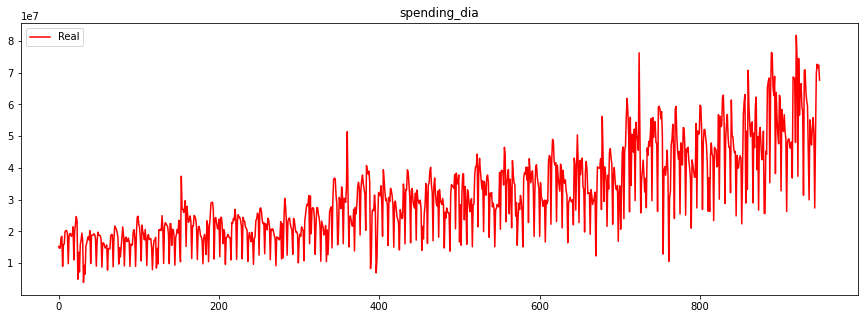

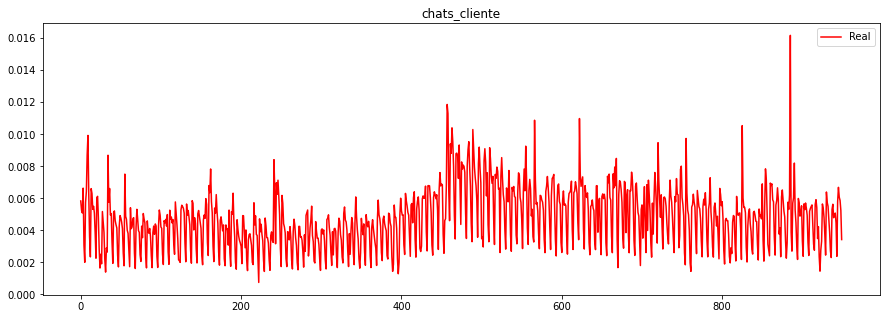

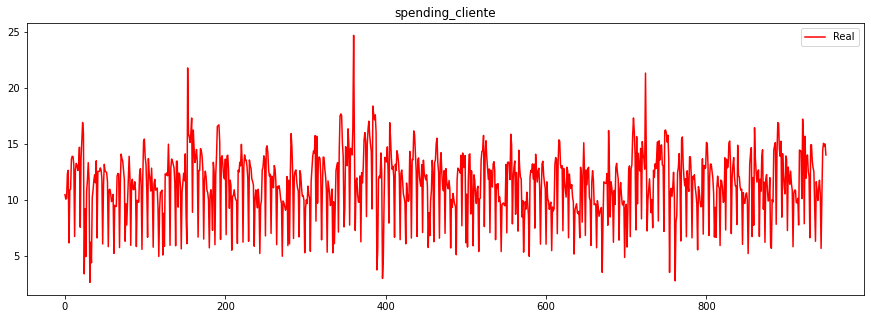

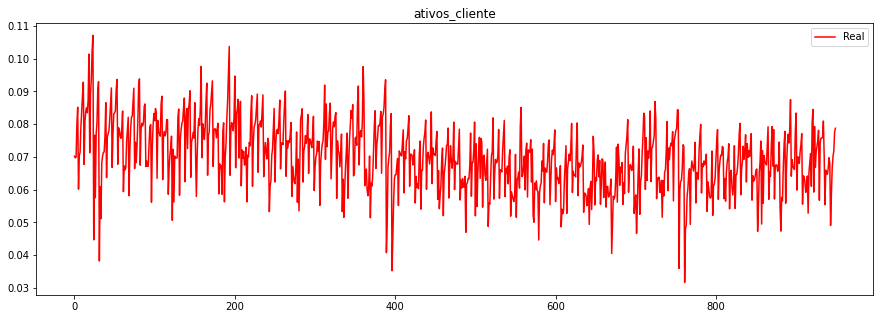

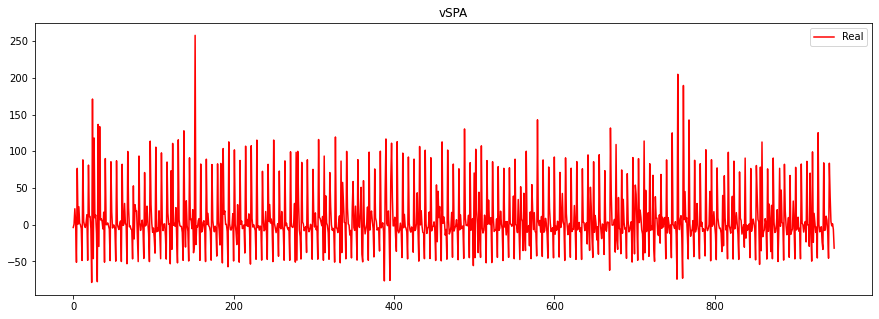

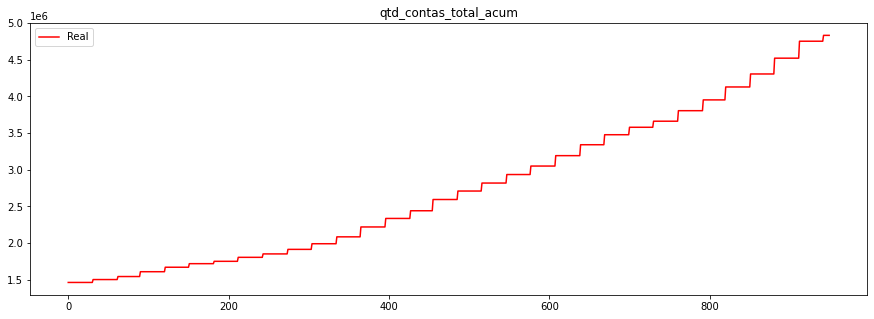

In [33]:
graficos = ['spending_dia', 'chats_cliente', 'spending_cliente',
       'ativos_cliente', 'vSPA', 'qtd_contas_total_acum']

for i in graficos:
  plt.figure(figsize=(15,5))
  plt.plot(df[i], color = 'red', label = 'Real')
  plt.legend()
  plt.title(i)

In [34]:
df[graficos].corr(method='pearson')

,spending_dia,chats_cliente,spending_cliente,ativos_cliente,vSPA,qtd_contas_total_acum
spending_dia,1.000000,0.433502,0.563965,0.105221,-0.390054,0.807909
chats_cliente,0.433502,1.000000,0.487597,0.026620,-0.312886,0.195101
spending_cliente,0.563965,0.487597,1.000000,0.713080,-0.690849,0.013254
ativos_cliente,0.105221,0.026620,0.713080,1.000000,-0.668260,-0.359223
vSPA,-0.390054,-0.312886,-0.690849,-0.668260,1.000000,-0.011137
qtd_contas_total_acum,0.807909,0.195101,0.013254,-0.359223,-0.011137,1.000000


In [177]:
df['ln_chats_cliente'] = np.log(df.chats_cliente)
df['ln_qtd_contas_total_acum'] = np.log(df.qtd_contas_total_acum)
df['ln_ativos_cliente'] = np.log(df.ativos_cliente)

In [179]:
formula_text = """
vSPA ~
+ C(ano) +C(dia) +C(mes) +C(dia_semana) +is_holiday +is_eve +flag_natal +flag_carnaval+ is_post+
ln_chats_cliente +
ln_qtd_contas_total_acum

"""
model = ols(formula = formula_text, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vSPA   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     131.6
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:32:49   Log-Likelihood:                -3863.1
No. Observations:                 950   AIC:                             7842.
Df Residuals:                     892   BIC:                             8124.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -132.7981    392.405     -0.338      0.735    -902.942     637.346
C(ano)[T.2021]                -5.1295     12.245     -0.419      0.675     -29.161      18.902
C(ano)[T.2022]               -10.5122     26.320     -0.399      0.690     -62.169      41.145
C(ano)[T.2023]               -15.3868     39.409     -0.390      0.696     -92.733      61.959
C(dia)[T.02]                  13.4926      3.664      3.682      0.000       6.301      20.684
C(dia)[T.03]                  36.9767      3.686     10.032      0.000      29.743      44.210
C(dia)[T.04]                   7.5549      3.755      2.012      0.045       0.184      14.925
C(dia)[T.05]                   6.6472      3.733      1.781      0.075      -0.679      13.974
C(dia)[T.06]                   4.4684      3.723      1.200      0.230      -2.838      11.775
C(dia)[T.07]                   7.9174      3.691      2.145      0.032       0.673      15.162
C(dia)[T.08]                  22.6296      3.691      6.131      0.000      15.386      29.874
C(dia)[T.09]                   9.8918      3.779      2.618      0.009       2.476      17.308
C(dia)[T.10]                   0.4264      3.768      0.113      0.910      -6.968       7.821
C(dia)[T.11]                   2.6991      3.747      0.720      0.472      -4.656      10.054
C(dia)[T.12]                  -1.3382      3.712     -0.361      0.719      -8.623       5.947
C(dia)[T.13]                  13.2562      3.734      3.550      0.000       5.927      20.586
C(dia)[T.14]                   0.4563      3.742      0.122      0.903      -6.888       7.801
C(dia)[T.15]                  -3.7423      3.696     -1.013      0.312     -10.996       3.512
C(dia)[T.16]                   0.8660      3.714      0.233      0.816      -6.424       8.156
C(dia)[T.17]                   2.9688      3.730      0.796      0.426      -4.352      10.290
C(dia)[T.18]                  26.6593      3.731      7.145      0.000      19.337      33.982
C(dia)[T.19]                   4.0122      3.771      1.064      0.288      -3.389      11.413
C(dia)[T.20]                  -2.5865      3.738     -0.692      0.489      -9.922       4.749
C(dia)[T.21]                   0.3090      3.693      0.084      0.933      -6.940       7.558
C(dia)[T.22]                   3.6875      3.730      0.989      0.323      -3.633      11.008
C(dia)[T.23]                   0.0129      3.731      0.003      0.997      -7.309       7.335
C(dia)[T.24]                   9.5527      3.811      2.506      0.012       2.072      17.033
C(dia)[T.25]                   7.8994      3.772      2.094      0.037       0.496      15.303
C(dia)[T.26]                   0.5726      3.730      0.153      0.878      -6.749       7.894
C(dia)[T.27]                   1.5844      

In [178]:
formula_text = """
vSPA ~
+ C(ano) +C(dia) +C(mes) +C(dia_semana) +is_holiday +is_eve +flag_natal +flag_carnaval+ is_post+
ln_chats_cliente +
ln_ativos_cliente

"""
model = ols(formula = formula_text, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vSPA   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     173.8
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:29:47   Log-Likelihood:                -3743.3
No. Observations:                 950   AIC:                             7603.
Df Residuals:                     892   BIC:                             7884.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -307.6580     23.860    -12.894      0.000    -354.487    -260.829
C(ano)[T.2021]               -10.9907      2.988     -3.678      0.000     -16.855      -5.126
C(ano)[T.2022]               -27.0851      3.304     -8.199      0.000     -33.569     -20.602
C(ano)[T.2023]               -27.2518      3.424     -7.959      0.000     -33.972     -20.531
C(dia)[T.02]                  10.1571      3.237      3.138      0.002       3.805      16.510
C(dia)[T.03]                  34.3001      3.253     10.543      0.000      27.915      40.685
C(dia)[T.04]                  17.5094      3.368      5.198      0.000      10.899      24.120
C(dia)[T.05]                  18.5771      3.374      5.506      0.000      11.955      25.199
C(dia)[T.06]                  15.7568      3.357      4.694      0.000       9.169      22.345
C(dia)[T.07]                  19.9098      3.339      5.962      0.000      13.356      26.464
C(dia)[T.08]                  36.5797      3.368     10.860      0.000      29.969      43.191
C(dia)[T.09]                  30.0947      3.562      8.448      0.000      23.103      37.086
C(dia)[T.10]                  24.7352      3.652      6.772      0.000      17.567      31.903
C(dia)[T.11]                  25.1977      3.590      7.018      0.000      18.151      32.244
C(dia)[T.12]                  22.7477      3.602      6.316      0.000      15.679      29.817
C(dia)[T.13]                  33.3145      3.523      9.457      0.000      26.401      40.228
C(dia)[T.14]                  23.0744      3.589      6.429      0.000      16.030      30.118
C(dia)[T.15]                  20.4252      3.591      5.687      0.000      13.377      27.474
C(dia)[T.16]                  21.4734      3.518      6.103      0.000      14.568      28.379
C(dia)[T.17]                  21.4647      3.485      6.158      0.000      14.624      28.305
C(dia)[T.18]                  43.5794      3.455     12.614      0.000      36.799      50.360
C(dia)[T.19]                  30.7745      3.721      8.270      0.000      23.471      38.078
C(dia)[T.20]                  25.7082      3.740      6.874      0.000      18.369      33.048
C(dia)[T.21]                  28.0823      3.690      7.611      0.000      20.841      35.324
C(dia)[T.22]                  28.3853      3.632      7.814      0.000      21.256      35.514
C(dia)[T.23]                  24.4614      3.626      6.746      0.000      17.344      31.578
C(dia)[T.24]                  30.0802      3.596      8.364      0.000      23.022      37.139
C(dia)[T.25]                  25.6874      3.506      7.326      0.000      18.806      32.569
C(dia)[T.26]                  17.5051      3.455      5.067      0.000      10.725      24.285
C(dia)[T.27]                  15.4132      

Text(0.5, 1.0, 'Previsão de série temporal')

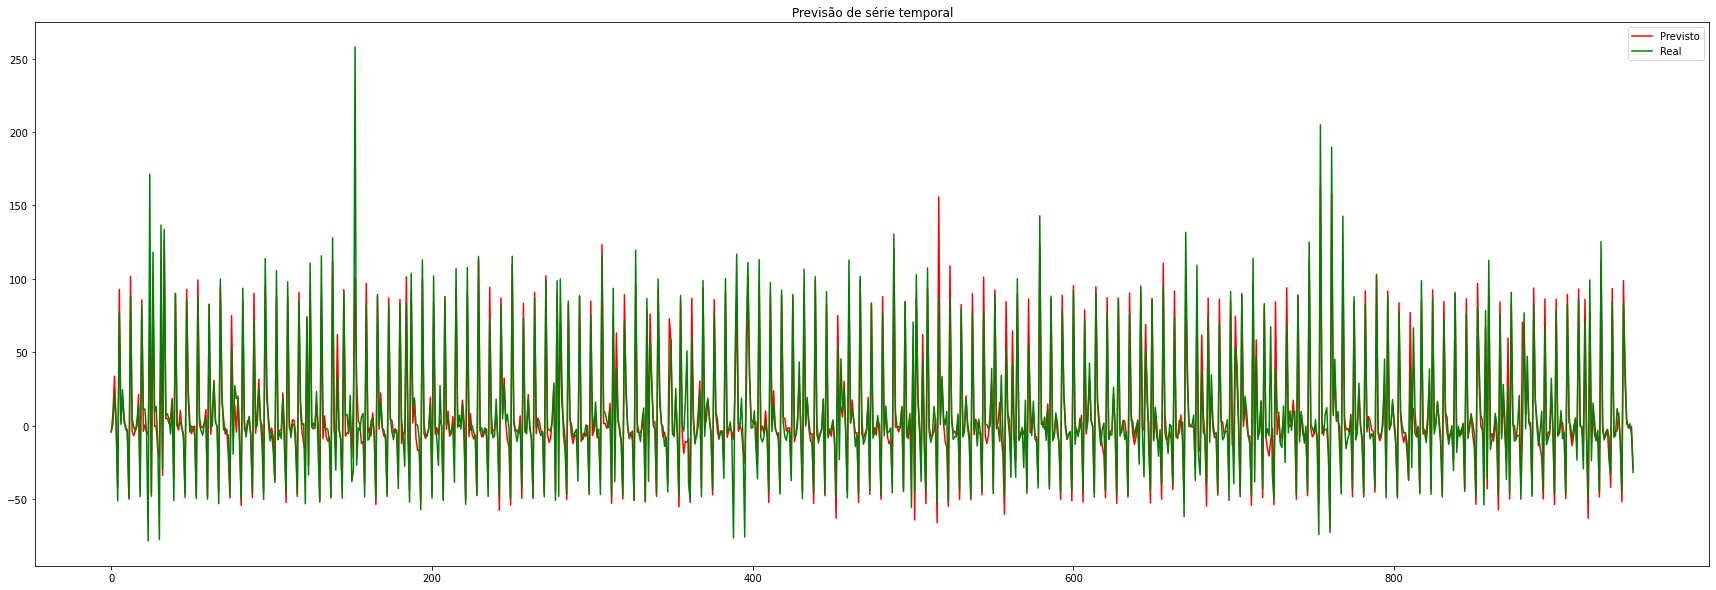

In [39]:
Ypred = np.array(model.predict(df))
Yreal = np.array(df['vSPA'])

plt.figure(figsize=(30,10))
plt.plot(Ypred, color = 'red', label = 'Previsto')
plt.plot(Yreal, color = 'green', label = 'Real')
plt.legend()
plt.title('Previsão de série temporal')

In [40]:
mape = np.mean(np.abs((Yreal - Ypred) / Yreal)) * 100
print(mape)

316.2972715388092


In [41]:
mape_med = np.median(np.abs((Yreal - Ypred) / Yreal)) * 100
print(mape_med)

39.95472077893727


In [43]:
mape_med = np.median(np.abs((Yreal[:30] - Ypred[:30]) / Yreal[:30])) * 100
print(mape_med)

52.10028129459653


In [44]:
df_sim = df[['spending_dia', 'ano', 'dia', 'mes', 'dia_semana', 'is_holiday', 'is_eve', 'flag_natal', 'flag_carnaval', 'is_post',  
'ln_qtd_contas_total_acum', 'qtd_contas_total_acum']]

In [150]:
meta_cr = -0.2
df_sim['chats_cliente'] = df['chats_cliente'] * (1 + meta_cr)

df[['chats_cliente']]

/tmp/ipykernel_2142053/626531209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['chats_cliente'] = df['chats_cliente'] * (1 + meta_cr)


,chats_cliente
0,0.005838
1,0.005259
2,0.005089
3,0.006638
4,0.003089
...,...
945,0.006688
946,0.006071
947,0.005876
948,0.005251


In [151]:
df_sim[['chats_cliente']]

,chats_cliente
0,0.004671
1,0.004207
2,0.004071
3,0.005311
4,0.002472
...,...
945,0.005351
946,0.004857
947,0.004701
948,0.004200


In [152]:
df_sim['ln_chats_cliente'] = np.log(df_sim['chats_cliente'])

/tmp/ipykernel_2142053/681139464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['ln_chats_cliente'] = np.log(df_sim['chats_cliente'])


In [153]:
var_sim = model.predict(df_sim)

In [154]:
var_sim

0      -4.435805
1       7.854071
2      33.638585
3       2.092711
4     -42.123560
         ...    
945     1.334155
946    -0.777322
947    -1.937586
948    -0.558593
949   -29.203359
Length: 950, dtype: float64

In [155]:
df_sim['vSPA_sim'] = var_sim

/tmp/ipykernel_2142053/4182401772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['vSPA_sim'] = var_sim


In [156]:
df_sim.vSPA_sim.describe()

count    950.000000
mean       7.742741
std       40.964697
min      -69.598534
25%       -8.244105
50%       -2.674772
75%        9.086978
max      163.370155
Name: vSPA_sim, dtype: float64

Text(0.5, 1.0, 'Previsão de série temporal')

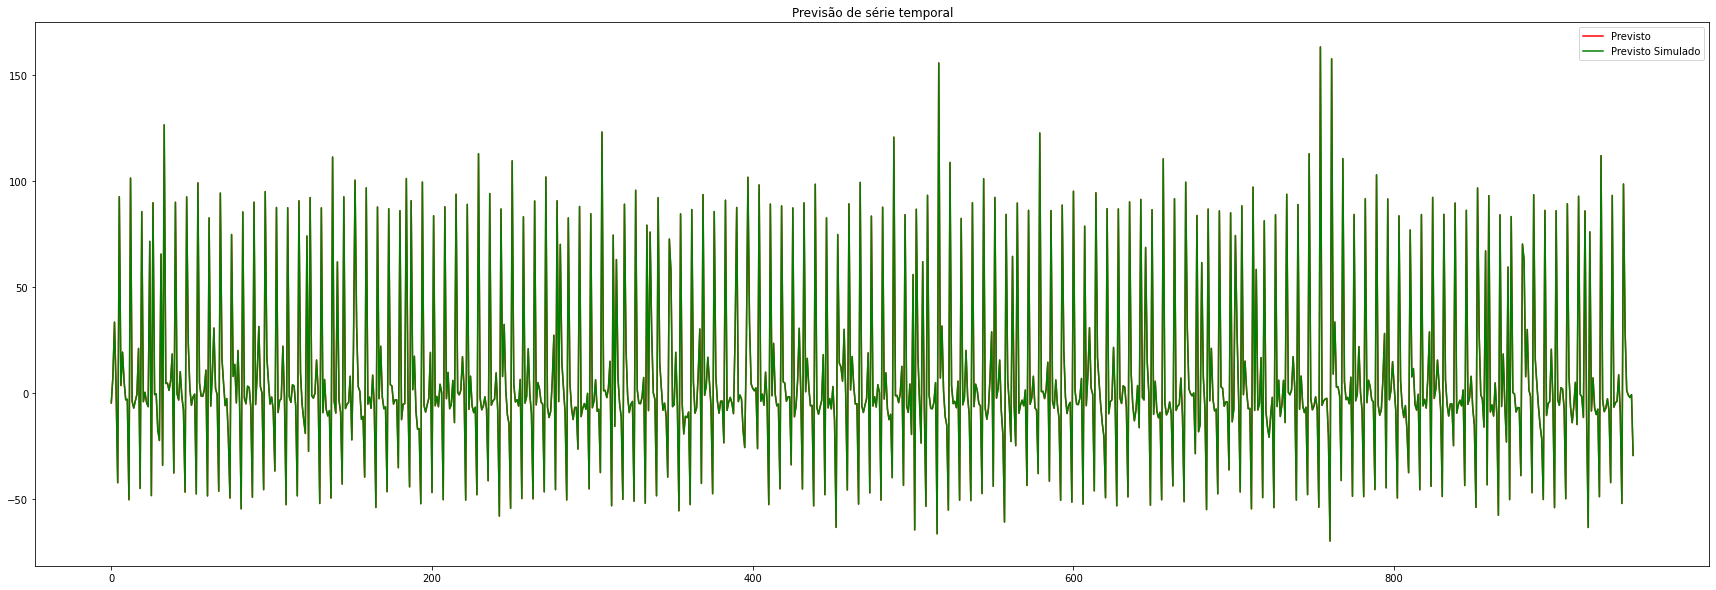

In [157]:
plt.figure(figsize=(30,10))
plt.plot(Ypred, color = 'red', label = 'Previsto')
plt.plot(df_sim.vSPA_sim, color = 'green', label = 'Previsto Simulado')
plt.legend()
plt.title('Previsão de série temporal')

In [158]:
#meta_cr = -0.1
#df['var_resposta'] = meta_cr * -0.7975
#df['vSPA_sim'] = df.vSPA * (df.var_resposta + 1)

#df_sim['vSPA_sim'] = np.where(df_sim['vSPA_sim'] > 9, df['vSPA'], df_sim['vSPA_sim'])
#df_sim['vSPA_sim'] = np.where(df_sim['vSPA_sim'] < -8, df['vSPA'], df_sim['vSPA_sim'])

df['spending_cliente_sim'] = (df['spending_cliente'].shift(-1) * (1 + (df_sim.vSPA_sim/100))).shift(1)
df['spending_dia_sim'] = df.spending_cliente_sim * df.qtd_contas_total_acum

    

In [159]:
df['spending_cliente_projetado'] = (df['spending_cliente'].shift(-1) * (1 + (Ypred/100))).shift(1)
df['spending_dia_projetado'] = df.spending_cliente_projetado * df.qtd_contas_total_acum

<AxesSubplot:ylabel='vSPA_sim'>

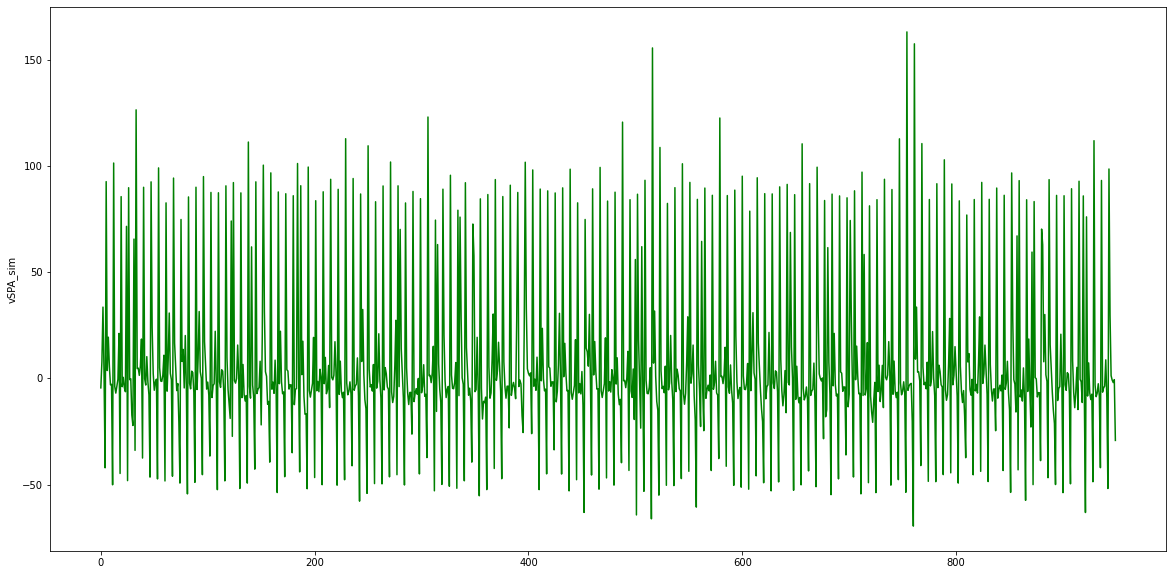

In [160]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df_sim.vSPA_sim, color="g")


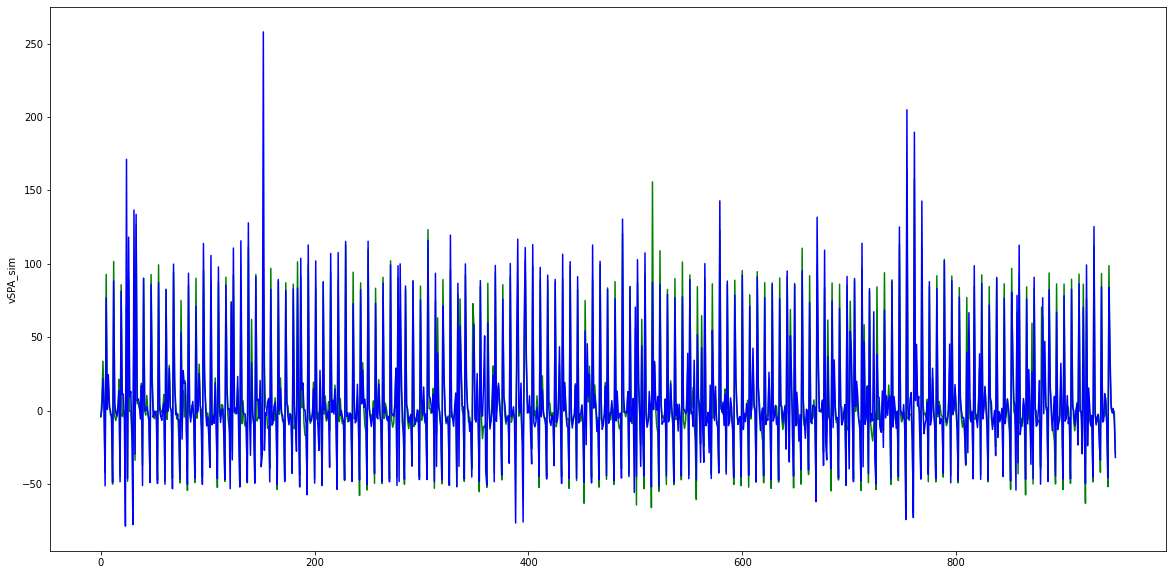

In [161]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df_sim.vSPA_sim, color="g")
sns.lineplot(data=df.vSPA, color="b")
plt.show()

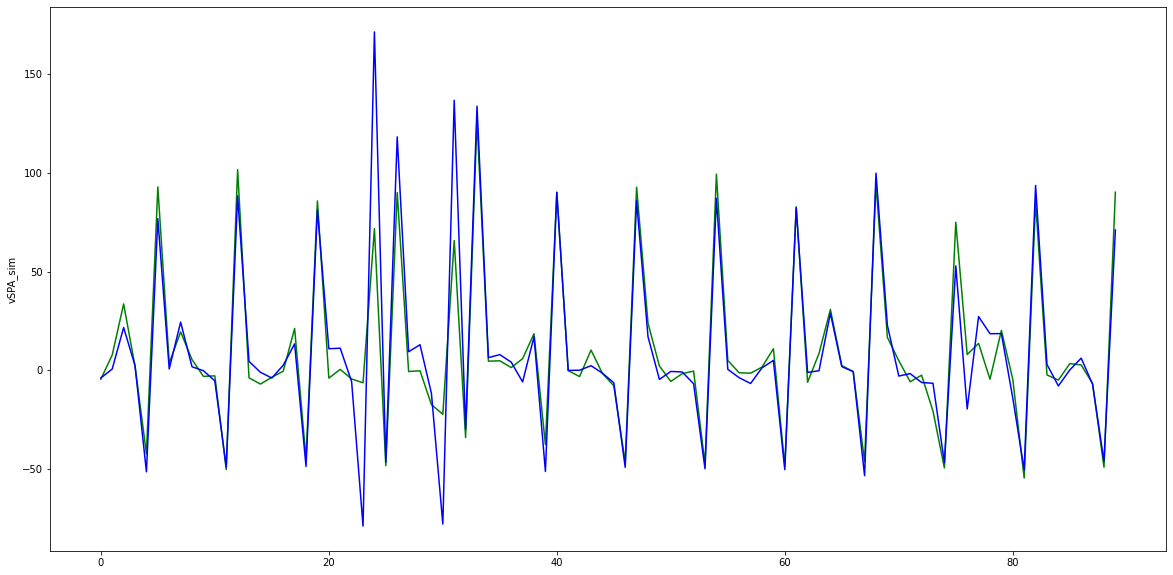

In [162]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df_sim.vSPA_sim[:90], color="g")
sns.lineplot(data=df.vSPA[:90], color="b")
plt.show()

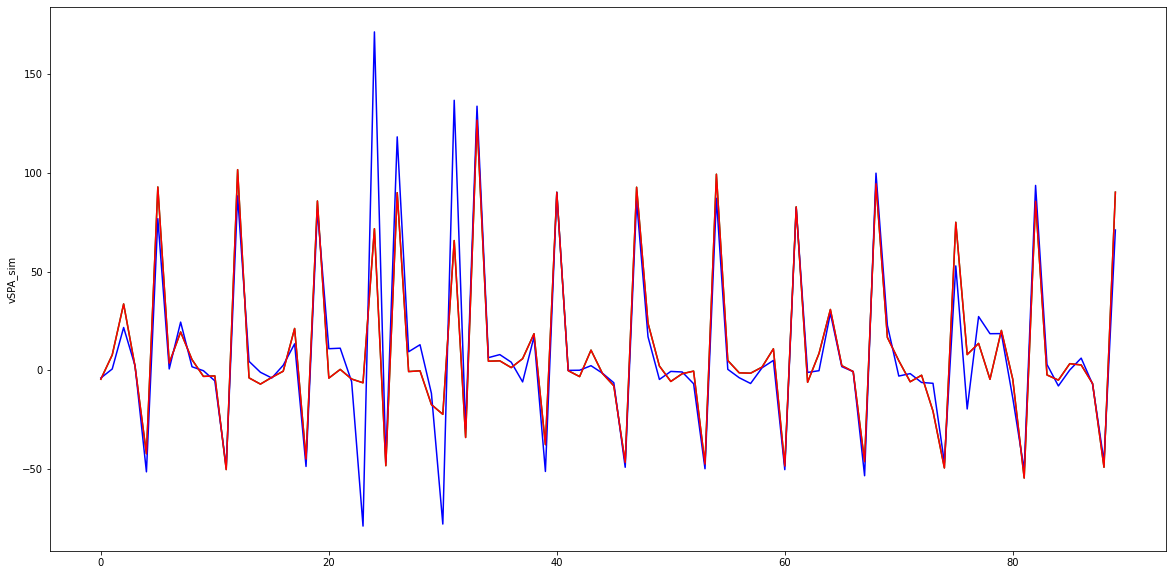

In [163]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df_sim.vSPA_sim[:90], color="g")
sns.lineplot(data=df.vSPA[:90], color="b")
sns.lineplot(data=Ypred[:90], color="r")
plt.show()

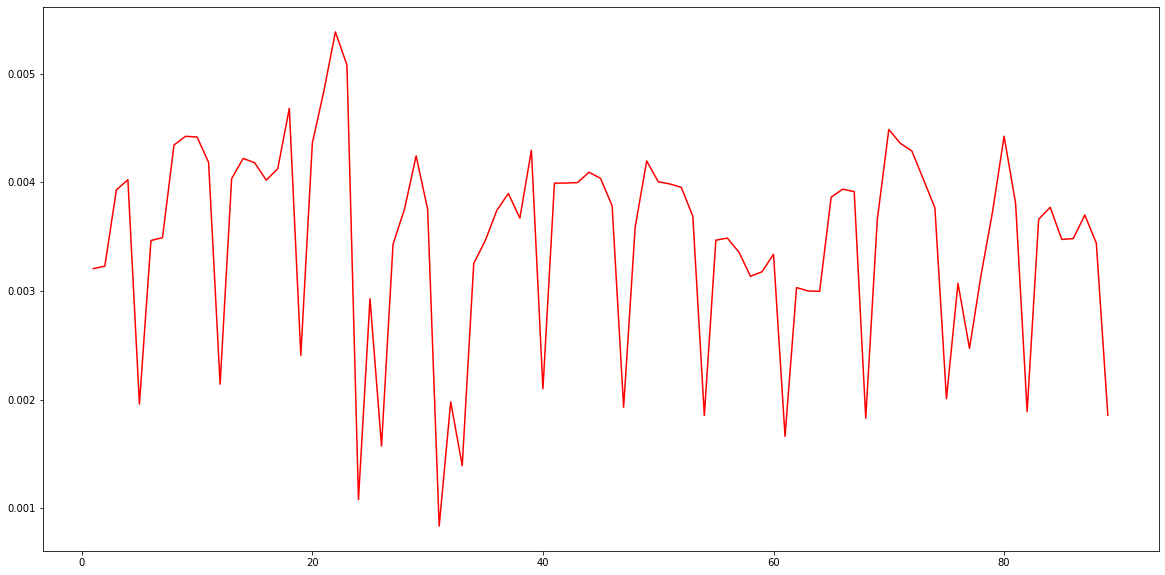

In [164]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.spending_cliente_sim[:90] - df.spending_cliente_projetado[:90] , color="r")
plt.show()

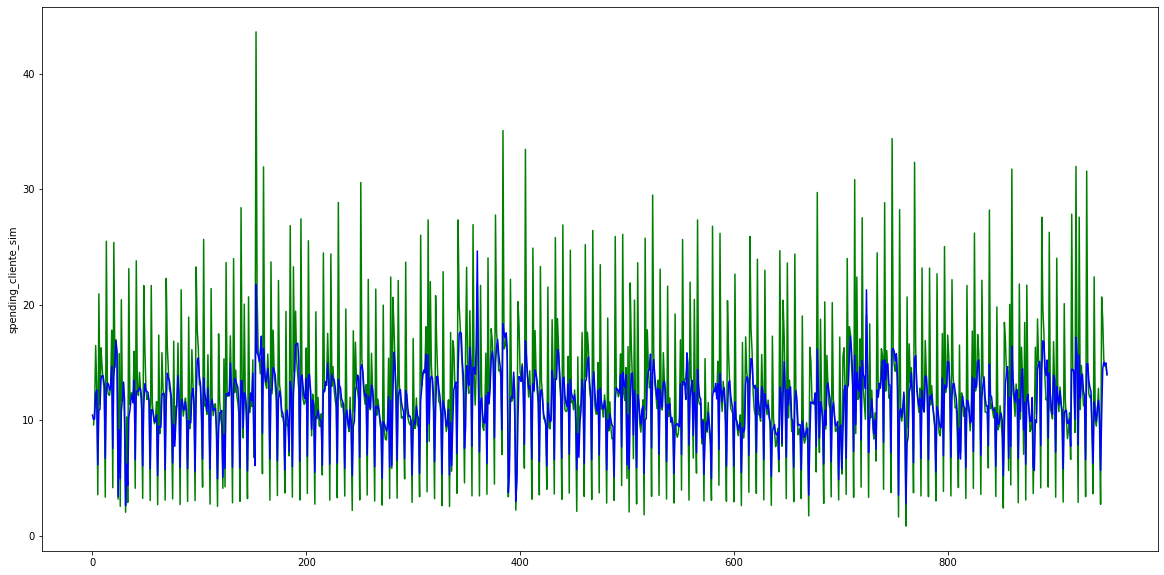

In [165]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.spending_cliente_sim, color="g")
sns.lineplot(data=df.spending_cliente, color="b")
plt.show()

<AxesSubplot:ylabel='spending_dia_sim'>

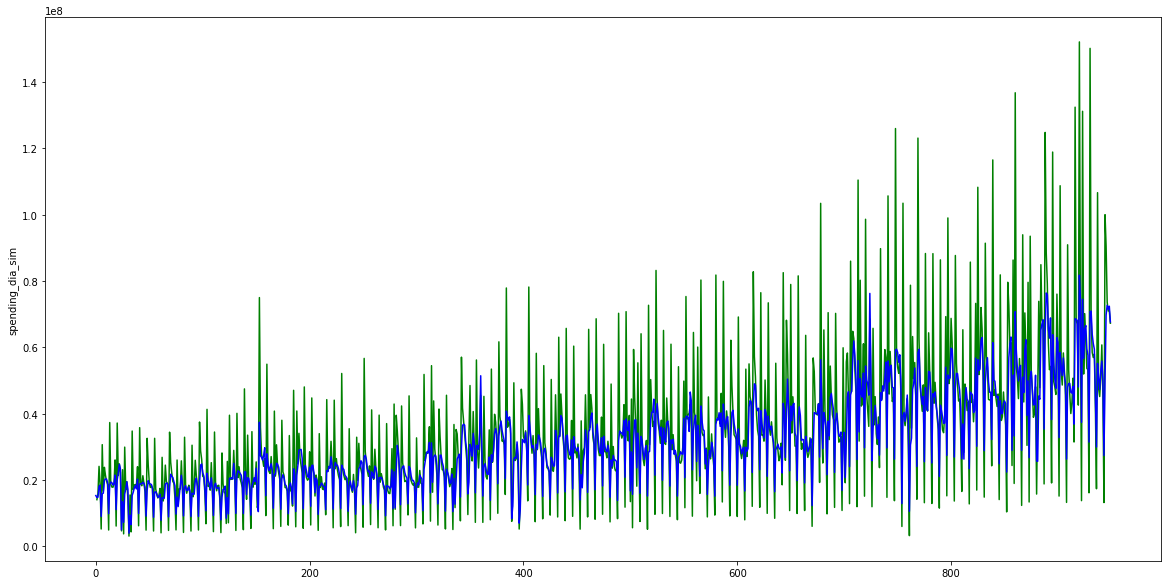

In [166]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.spending_dia_sim, color="g")
sns.lineplot(data=df.spending_dia, color="b")

<AxesSubplot:ylabel='chats'>

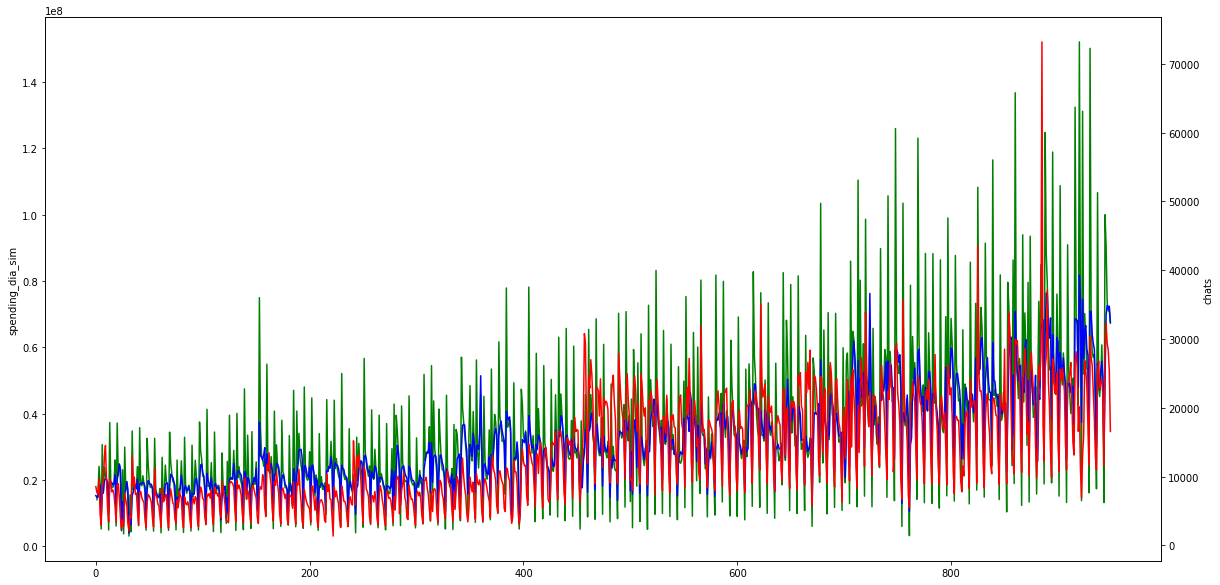

In [167]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.spending_dia_sim, color="g")
sns.lineplot(data=df.spending_dia, color="b")
ax3 = plt.twinx()
sns.lineplot(data=df.chats, color="r", ax=ax3)

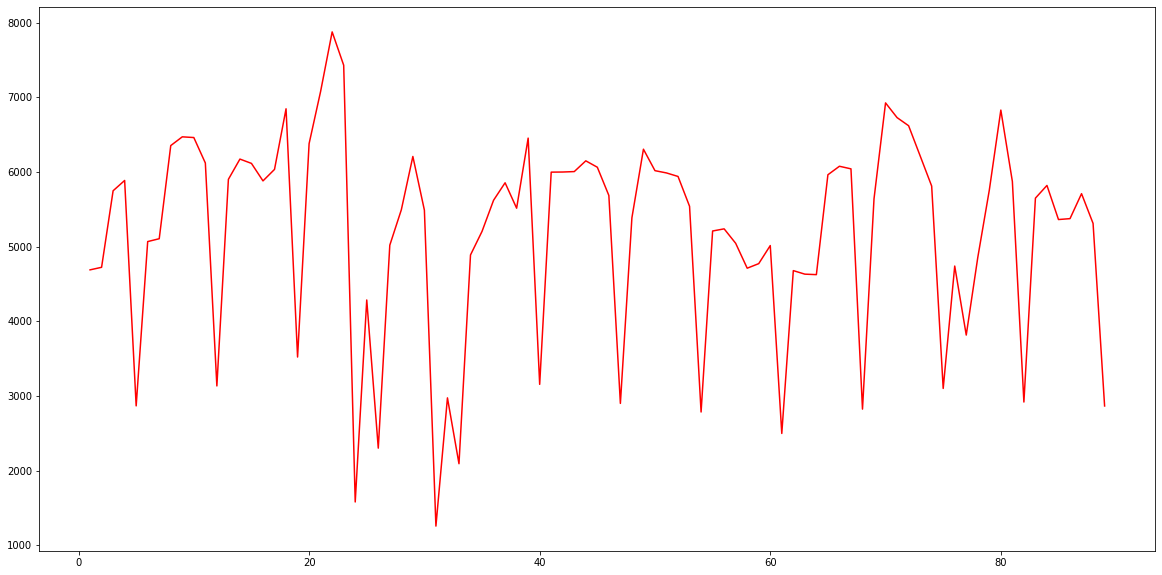

In [168]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.spending_dia_sim[:90] - df.spending_dia_projetado[:90] , color="r")
plt.show()

In [169]:
df['impacto'] = df.spending_dia_sim - df.spending_dia

In [170]:
df['impacto2'] = df.spending_dia_sim - df.spending_dia_projetado

<AxesSubplot:ylabel='chats'>

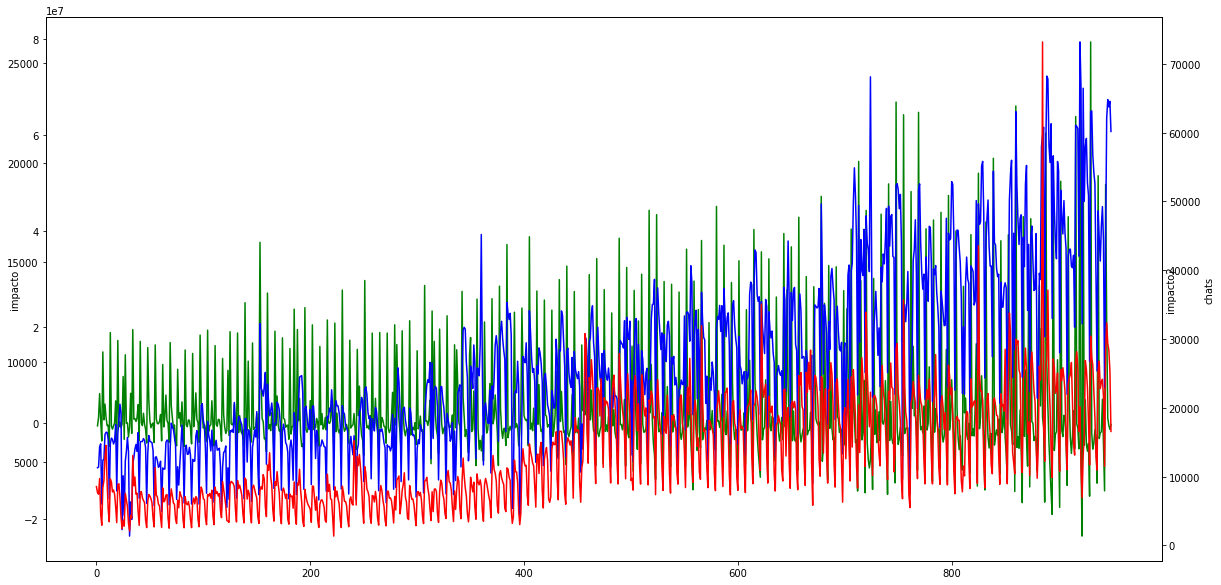

In [171]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.impacto, color="g")
ax2 = plt.twinx()
sns.lineplot(data=df.impacto2, color="b", ax=ax2)
ax3 = plt.twinx()
sns.lineplot(data=df.chats, color="r", ax=ax3)

In [172]:
sim_agg = df.groupby(['ano', 'mes']).agg({'spending_dia_sim':['sum'], 'spending_dia':['sum']
                                          ,'spending_dia_projetado':['sum'], 'impacto':['sum'], 'impacto2':['sum']})
sim_agg.columns = sim_agg.columns.droplevel(1)

In [173]:
sim_agg['impacto_percentual'] = sim_agg['impacto'] / sim_agg['spending_dia']

In [174]:
sim_agg['impacto_percentual2'] = sim_agg['impacto2'] / sim_agg['spending_dia']

In [175]:
sim_agg

spending_dia_sim  spending_dia  spending_dia_projetado  \
ano  mes                                                           
2020 12       5.744095e+08     524288971            5.742473e+08   
2021 01       5.456597e+08     477703700            5.455074e+08   
     02       5.075858e+08     460435701            5.074391e+08   
     03       6.193896e+08     542762185            6.192166e+08   
     04       6.321736e+08     558128979            6.319957e+08   
     05       7.650517e+08     668513956            7.648386e+08   
     06       6.891658e+08     617511372            6.889690e+08   
     07       6.921060e+08     629633464            6.919053e+08   
     08       7.027553e+08     627940900            7.025551e+08   
     09       6.683411e+08     602273107            6.681491e+08   
     10       7.762723e+08     697450740            7.760500e+08   
     11       9.190518e+08     823271564            9.187893e+08   
     12       9.826540e+08     890438714            9.823701e+08   
2022 01       9.628138e+08     829424722            9.625494e+08   
     02       8.738675e+08     798407113            8.736130e+08   
     03       9.997406e+08     896873914            9.994547e+08   
     04       1.008136e+09     890144804            1.007852e+09   
     05       1.104294e+09     981573361            1.103981e+09   
     06       1.068510e+09     968368890            1.068201e+09   
     07       1.105543e+09    1009025144            1.105221e+09   
     08       1.221568e+09    1092940964            1.221220e+09   
     09       1.134490e+09    1018437013            1.134165e+09   
     10       1.248801e+09    1102718441            1.248450e+09   
     11       1.478136e+09    1331531989            1.477711e+09   
     12       1.543478e+09    1386964247            1.543036e+09   
2023 01       1.506394e+09    1290631026            1.505982e+09   
     02       1.329368e+09    1220842846            1.328979e+09   
     03       1.595884e+09    1453613626            1.595421e+09   
     04       1.581835e+09    1420465182            1.581382e+09   
     05       1.868096e+09    1672554234            1.867563e+09   
     06       1.908801e+09    1699267574            1.908259e+09   
     07       5.324927e+08     482272667            5.323390e+08   

               impacto       impacto2  impacto_percentual  impacto_percentual2  
ano  mes                                                                        
2020 12   6.541684e+07  162252.689621            0.124772             0.000309  
2021 01   6.795602e+07  152278.634576            0.142256             0.000319  
     02   4.715012e+07  146774.077442            0.102403             0.000319  
     03   7.662739e+07  173017.467587            0.141180             0.000319  
     04   7.404462e+07  177915.973519            0.132666             0.000319  
     05   9.653774e+07  213103.629749            0.144406             0.000319  
     06   7.165446e+07  196845.426491            0.116037             0.000319  
     07   6.247252e+07  200709.611797            0.099220             0.000319  
     08   7.481440e+07  200170.069535            0.119142             0.000319  
     09   6.606802e+07  191987.892025            0.109698             0.000319  
     10   7.882159e+07  222327.870542            0.113014             0.000319  
     11   9.578019e+07  262436.044876            0.116341             0.000319  
     12   9.221527e+07  283847.061560            0.103562             0.000319  
2022 01   1.333891e+08  264397.500269            0.160821             0.000319  
     02   7.546039e+07  254509.950421            0.094514             0.000319  
     03   1.028667e+08  285898.424087            0.114695             0.000319  
     04   1.179914e+08  283753.371238            0.132553             0.000319  
     05   1.227204e+08  312898.248745            0.125024             0.000319  
     06   1.001413e+08  308689.031160            0.103412             0.00031